(256, 256, 3) 1.0 0.0 (256, 256, 3) 1.0 0.0
Input	Proposal	baseline


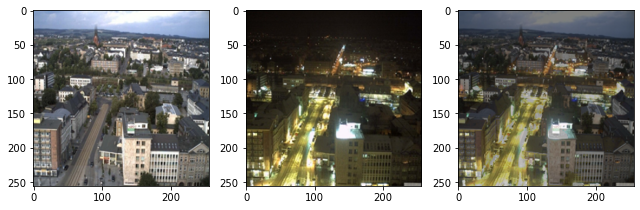

In [72]:
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import change_range, basic_normalization, change_range_tensor, norm_tensor, norm_numpy

def show_pair(pair):
    plt.figure(figsize=(3*len(pair), 3))
    for i, x in enumerate(pair):
        plt.subplot(1, len(pair), i + 1)
        plt.imshow(x)
    plt.tight_layout()
    plt.show()

trainA = plt.imread("Images/epoch009_real_A_raw.png")
trainB = plt.imread("Images/epoch009_real_B_raw.png")
use_both_a = True
alpha = 0.5
n_channels = 1
if trainA.max() > 1:
    trainA = trainA.astype(np.float) / 255.
if trainB.max() > 1:
    trainB = trainB.astype(np.float) / 255.
print(trainA.shape, trainA.max(), trainA.min(), trainB.shape, trainB.max(), trainB.min())

imgA = trainA * 255
imgB = trainB * 255
baseline_diff = trainB - trainA * alpha
baseline = (trainA * alpha + np.minimum(np.maximum(baseline_diff, 0), 1 - alpha)) * 255

print("Input\tProposal\tbaseline")
pair = (trainA, trainB, baseline / 255.)
show_pair(pair)

In [15]:
# Poisson Image Editing
# equation 3
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Gradient_Net(nn.Module):
    def __init__(self):

        super(Gradient_Net, self).__init__()
        kernel_x = [[1., 0., -1.], [2., 0., -2.], [1., 0., -1.]]
        # kernel_x = [[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]
        kernel_x = torch.FloatTensor(kernel_x).unsqueeze(0).unsqueeze(0)
        kernel_y = [[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]]
        #kernel_y = [[-3, -10, -3], [0, 0, 0], [3, 10, 3]]
        kernel_y = torch.FloatTensor(kernel_y).unsqueeze(0).unsqueeze(0)
        self.weight_x = nn.Parameter(data=kernel_x, requires_grad=False)
        self.weight_y = nn.Parameter(data=kernel_y, requires_grad=False)

    def forward(self, x):
        # x: 1 * 256 * 256 * 3
        grad_out = []
        for channel in range(x.shape[-1]):
            # 1 * 1 * 256 * 256 
            x_i = x[:, :, :, channel].unsqueeze(1)
            # set bias = False 
            grad_x = F.conv2d(x_i, self.weight_x, padding = 1)
            grad_y = F.conv2d(x_i, self.weight_y, padding = 1)
            # grad_x, grad_y : 1 * 2 * 256 * 256
            gradient = torch.cat([grad_x, grad_y], dim = 1)
            # grad_out.append(grad_y)
            grad_out.append(gradient)
        # bs * (channel * 2) * h * w
        return torch.cat(grad_out, dim=1)
        # return torch.stack(grad_out, -1).squeeze(0)

<IPython.core.display.Javascript object>


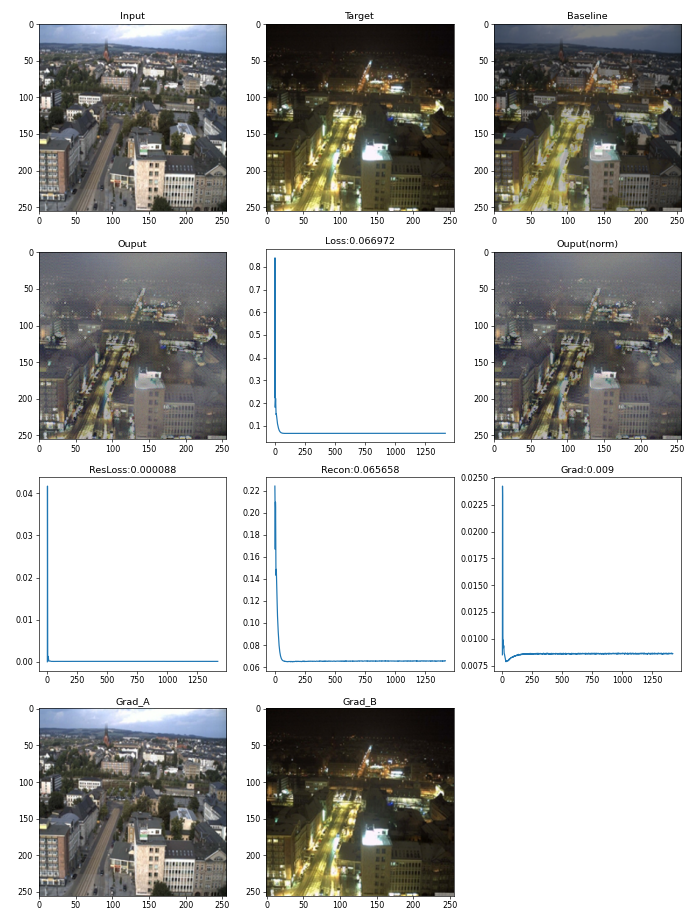

In [73]:
%matplotlib notebook
import matplotlib.pyplot as plt


figsize = 4
r, c = 4, 3

fig = plt.figure(figsize=(c * figsize, r * figsize))
ax1 = fig.add_subplot(r, c, 5)
ax1.plot([], [])
ax1.set_title("Loss")

# ax2 = fig.add_subplot(r, c, 2)
# ax2.plot([], [])
# ax2.set_title("Offset")

ax4 = fig.add_subplot(r, c, 9)
ax4.plot([], [])
ax4.set_title("Gradient")

ax3 = fig.add_subplot(r, c, 7)
ax3.plot([], [])
ax3.set_title("ResLoss")

ax7 = fig.add_subplot(r, c, 8)
ax7.plot([], [])
ax7.set_title("Recon")

###################
# Original view
###################

axinp = fig.add_subplot(r, c, 1)
axinp.imshow(imgA.astype(np.int))
axinp.set_title("Input")

axtrg = fig.add_subplot(r, c, 2)
axtrg.imshow(imgB.astype(np.int))
axtrg.set_title("Target")

axbase = fig.add_subplot(r, c, 3)
axbase.imshow(baseline.astype(np.int))
axbase.set_title("Baseline")

ax6 = fig.add_subplot(r, c, 4)
ax6.imshow(imgA.astype(np.int))
ax6.set_title("Output")

ax5 = fig.add_subplot(r, c, 10)
ax5.imshow(imgA.astype(np.int))
ax5.set_title("Grad_A")

ax8 = fig.add_subplot(r, c, 11)
ax8.imshow(imgB.astype(np.int))
ax8.set_title("Grad_B")
###################
# Normalized view
###################

# axbase_norm = fig.add_subplot(r, c, 10)
# axbase_norm.imshow(norm_numpy(baseline).astype(np.int))
# axbase_norm.set_title("Baseline(norm)")

ax6_norm = fig.add_subplot(r, c, 6)
ax6_norm.imshow(imgA.astype(np.int))
ax6_norm.set_title("Output(norm)")

# axtrg_norm = fig.add_subplot(r, c, 12)
# axtrg_norm.imshow(norm_numpy(imgB).astype(np.int))
# axtrg_norm.set_title("Target(norm)")

plt.tight_layout()
plt.show()




In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import tqdm


lr = 1e-1

# change into singel param
# a = nn.Parameter(torch.ones(1, 1, n_channels))
# b = nn.Parameter(torch.zeros(1, 1, n_channels))

residual = nn.Parameter(torch.zeros(256, 256, 3), requires_grad = True)
# residual = nn.Parameter(torch.zeros(256, 256, 3), requires_grad = True)
    
# optim = Adam([a, b], lr=lr)
optim = Adam([residual], lr = lr)
total_iters = 10000
resloss_weight = 15
losses = []
offsets = []
res_losses = []
offset_grads = []
recon_losses = []

grad_net = Gradient_Net()
# outer loop: include all the images in dataset 
# inner loop: alpha
# most inner loop: 
for i in tqdm.tqdm(range(total_iters)):
    optim.zero_grad()
    A_tensor = torch.from_numpy(trainA).float()  # input
    A_rescaled = change_range_tensor(A_tensor, alpha, 0.) # input after sunglasses: alpha * input
    B_tensor = torch.from_numpy(trainB).float()  # target/psedo-label
    
    # B_rescaled = B_tensor * a + b
    # residual = B_rescaled - A_rescaled
        
    clipped_residual = torch.clamp(residual, min=0, max=1 - alpha)
    real_output = clipped_residual + A_rescaled

    # 1*6*256*256
    grad_b = grad_net(B_tensor.view((1, 256, 256, 3)))
    grad_a = grad_net(real_output.view((1, 256, 256, 3)))
    # 1*6*256*256
    recon_loss_all = torch.abs(grad_b - grad_a)
    
    random_mask = torch.ones_like(recon_loss_all) 
    random_mask[:, :, 0, :] = 0
    random_mask[:, :, -1, :] = 0
    random_mask[:, :, :, 0] = 0
    random_mask[:, :, :, -1] = 0

    recon_loss = (recon_loss_all * random_mask).mean() 
    
    # recon_loss = recon_loss_all.mean()
    random_mask = torch.ones_like(residual)
    
    residual_loss = (torch.abs(clipped_residual - residual) * random_mask).mean()
    # res_loss_weight = 0
    loss = recon_loss + residual_loss * resloss_weight
    loss.backward()
    
    offset_grads.append((
        residual.grad.clone().norm().item() if residual.grad is not None else 0.))
    optim.step()

#     offset_grads.append((
#         a.grad.clone().norm().item() if a.grad is not None else 0, 
#         b.grad.clone().norm().item() if b.grad is not None else 0.))
#     optim.step()
    
    losses.append(loss.item())
    # offsets.append((a.clone().detach().mean().item(), b.clone().detach().mean().item()))
    offsets.append((residual.clone().detach().mean().item()))
    recon_losses.append(recon_loss.clone().detach().item())
    res_losses.append(residual_loss)
    
    
    if (i + 1) % 10 == 0:
        ax1.clear()
        ax1.plot(range(len(losses)), losses)
        ax1.set_title("Loss:%.6f" % losses[-1])
        
        ax3.clear()
        ax3.plot(range(len(res_losses)), res_losses)
        ax3.set_title("ResLoss:%.6f" % res_losses[-1])
        
        ax4.clear()
        ax4.plot(range(len(offset_grads)), [offfff for offfff in offset_grads], label="res grad")
        ax4.set_title("Grad:%.3f" % (offset_grads[-1])) 
        
        ax7.clear()
        ax7.plot(range(len(recon_losses)), recon_losses)
        ax7.set_title("Recon:%.6f" % recon_losses[-1])
        
        ax6_norm.clear()
        ax6_norm.imshow((norm_tensor(real_output).cpu().detach().numpy() * 255.).astype(np.int))
        ax6_norm.set_title("Ouput(norm)")
        
        ax6.clear()
        ax6.imshow((real_output.cpu().detach().numpy() * 255.).astype(np.int))
        ax6.set_title("Ouput")
        fig.canvas.draw()
        
#         ax5.clear()
#         ax5.imshow((grad_a.view((2, 256,256,3)).cpu().detach().numpy() * 255.).astype(np.int))
#         ax5.set_title("Grad_A")
#         fig.canvas.draw()
        
#         ax8.clear()
#         ax8.imshow((grad_b.view((2, 256,256,3)).cpu().detach().numpy() * 255.).astype(np.int))
#         ax8.set_title("Grad_B")
#         fig.canvas.draw()
        
        
        

 14%|█▍        | 1423/10000 [02:35<15:35,  9.17it/s]


KeyboardInterrupt: 

In [70]:
print(imgB.min(), imgB.max())

0.0 233.0


<IPython.core.display.Javascript object>


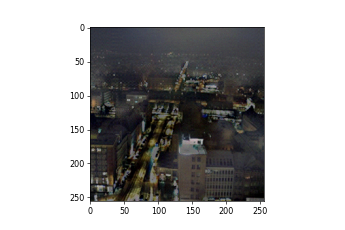

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [81]:
plt.imshow((real_output.cpu().detach().numpy() * 255. - 50).astype(np.int))